# Active Learning on Covid lung scans with VGG16

We will use tensorflow to import the vgg 16 model.  
The dataset can be found here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

## Loading dataset and creating training and test set

!pip cache purge  
!pip install -r ../requirements.txt --no-cache-dir

In [1]:
import os

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Used for converting 24 bit to 8 bit images
from PIL import Image

# Import classifiers and performance metrics
# from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
# from skactiveml.pool import UncertaintySampling
# from skactiveml.utils import unlabeled_indices, MISSING_LABEL
# from skactiveml.classifier import SklearnClassifier

#from keras.applications.vgg16 import VGG16

In [2]:
# Three main subfolders: COVID, Normal, Viral Pneumonia
subfolders = ["COVID/", "Normal/", "Viral Pneumonia/"]
#subfolders = ["Normal/"]
path = "ActiveLearning_ImageClassification/COVID-19_Radiography_Dataset/"
data = {}
size = 0

# Every subfolder has images and their masks
for subfolder in subfolders:
    data[subfolder + "images"] = [path + subfolder + "images/" + image for image in os.listdir(path + subfolder + "images")]
    data[subfolder + "masks"] = [path + subfolder + "masks/" + image for image in os.listdir(path + subfolder + "masks")]
    print(f"Number of images in {subfolder}: {len(data[subfolder + 'images'])}")
    print(f"Number of masks in {subfolder}: {len(data[subfolder + 'masks'])}")
    size += len(data[subfolder + 'images'])
                
print(f"Total size: {str(size)}")

Number of images in COVID/: 3616
Number of masks in COVID/: 3616
Number of images in Normal/: 10192
Number of masks in Normal/: 10192
Number of images in Viral Pneumonia/: 1345
Number of masks in Viral Pneumonia/: 1345
Total size: 15153


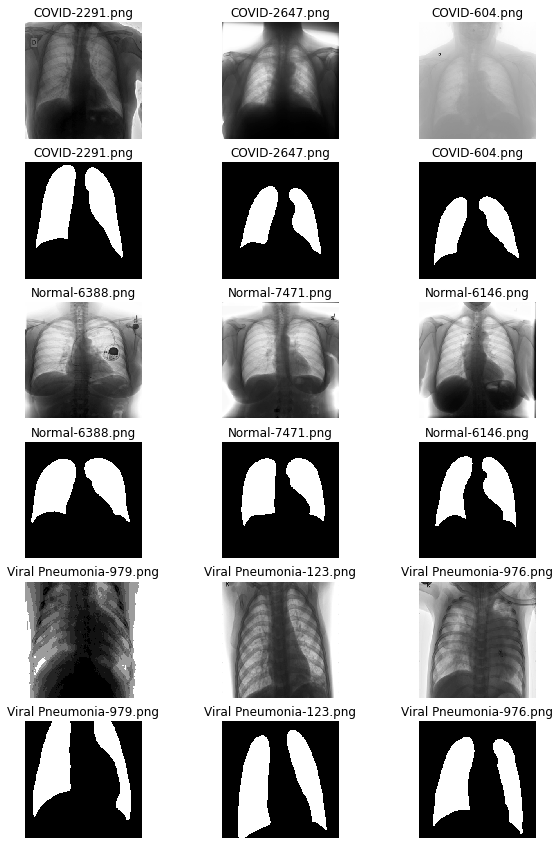

In [3]:
# Load image paths and show 3 examples of the scans, both image and mask

# Tunable parameters
num_images = 3 # number of images to show
versions = ["images", "masks"] # show both image and mask, default: ["images", "masks"]

examples_path = []
examples_images = []

for subfolder in subfolders:
    for version in versions:
        examples_path += data[subfolder + version][0:num_images]
        for image in examples_path[-num_images:]:
            examples_images.append(plt.imread(image))

_, axes = plt.subplots(nrows=len(subfolders) * len(versions), ncols=num_images, figsize=(10, 15))
for ax, image, label in zip(axes.flatten(), examples_images, examples_path):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%s" % label.split("/")[-1])

In [4]:
# Restric memory usage
for subfolder in subfolders:
    print(len(data[subfolder + "images"]))
    data[subfolder + "images"] = data[subfolder + "images"][0:1000]
    
size = 3000

for subfolder in subfolders:
    print(len(data[subfolder + "images"]))

3616
10192
1345
1000
1000
1000


(224, 224, 3)
(224, 224, 3)
uint8


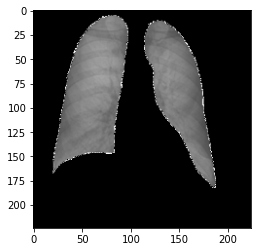

In [5]:
image = data["COVID/" + "images"][0]

# Convert image to 224,224,3
img = Image.open(image)
new_img = img.convert("RGB")
new_img = new_img.resize(size=(224, 224))
np_image = np.array(new_img)

mask = data["COVID/" + "masks"][0]
# Convert mask to 224,224,3
msk = Image.open(mask)
new_msk = msk.resize(size=(224, 224))
np_mask = np.array(new_msk)

print(np_image.shape)
print(np_mask.shape)

new_image = np.multiply(np_image, np_mask)
print(new_image.dtype)
imgplot = plt.imshow(new_image)

In [6]:
# Create the training data, might take a while

X = np.zeros((size, 224, 224, 3), dtype=np.uint8)
index = 0
test = 0
for subfolder in subfolders:
    for i, image_path in enumerate(data[subfolder + "images"]):
        image = plt.imread(image_path)
        
        # Some images are not 8 bit, so we convert them
        if (len(image.shape) != 2):
            img = Image.open(image_path)
            new_img = img.convert("L")
            new_img.save(image_path)
        
        # Convert image to 224,224,3
        img = Image.open(image_path)
        new_img = img.convert("RGB")
        new_img = new_img.resize(size=(224, 224))
        np_image = np.array(new_img)

        mask = data[subfolder + "masks"][i]
        # Convert mask to 224,224,3
        msk = Image.open(mask)
        new_msk = msk.resize(size=(224, 224))
        np_mask = np.array(new_msk)

        new_image = np.multiply(np_image, np_mask)
        
        X[index] = new_image
        index += 1

print(len(X))
y = np.concatenate([np.array([subfolder[:-1]] * len(data[subfolder + "images"])) for subfolder in subfolders])
print(len(y))

3000
3000


254


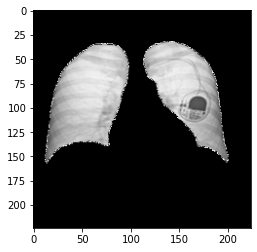

In [10]:
imgplot = plt.imshow(X[1000])
print(np.max(X[0]))

In [11]:
# Split the dataset in training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [12]:
# Save the training data
np.save(path + "x_train", X_train)
np.save(path + "x_test", X_test)
np.save(path + "y_train", y_train)
np.save(path + "y_test", y_test)

In [4]:
path = "ActiveLearning_ImageClassification/COVID-19_Radiography_Dataset/"

# Load training data
X_train = np.load(path + "x_train.npy")
X_test = np.load(path + "x_test.npy")
y_train = np.load(path + "y_train.npy")
y_test = np.load(path + "y_test.npy")
print(X_train.shape)

(2400, 224, 224, 3)


## Start Training model

In [6]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy



model = VGG16(weights=None)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(x=X_train, y=y_train)

ValueError: in user code:

    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/user/gent/449/vsc44961/.local/lib/python3.9/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (32, 1) and (32, 1000) are incompatible
